In [2]:
import neutromeratio
import pickle
from neutromeratio.constants import kT
import pandas as pd
from simtk import unit
from neutromeratio.plotting import plot_correlation_analysis
from neutromeratio.constants import kT, exclude_set_ANI, exclude_set_B3LYP, mols_with_charge, multiple_stereobonds
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem, Geometry
import seaborn as sb
from rdkit.Chem import AllChem
import networkx as nx
from collections import defaultdict
from neutromeratio.analysis import prune_conformers, calculate_weighted_energy

[__init__.py:17 - <module>()] Enabling RDKit 2020.09.3 jupyter extensions


[utils.py:157 - _init_num_threads()] NumExpr defaulting to 8 threads.


In [3]:
# load the experimental and ANI RRHO results
exp_results = pickle.load(open('../data/input/exp_results.pickle', 'rb'))
ani_results = pickle.load(open('../data/calculated/ANI1ccx_RRHO.pickle', 'rb'))

In [7]:
# Read in the alchemical free energy results for all 5 independent runs
from collections import defaultdict
results = defaultdict(list)
error = defaultdict(list)
base = '../data/calculated/'
for rep in ['p1', 'p2', 'p3', 'p4', 'p5']:
    csv_file = f'{base}/ANI1ccx_vacuum_rfe_results_in_kT_300snapshots_{rep}.csv'
    f = open(csv_file, 'r')
    for line in f.readlines():
        name, ddG, dddG = (line.split(','))
        results[name].append((float(ddG) *kT).value_in_unit(unit.kilocalorie_per_mole))
        error[name].append((float(dddG) *kT).value_in_unit(unit.kilocalorie_per_mole))

In [8]:
# filter based on stddev of free energy estimate of the 5 independent runs
small_stddev = []
for name in results:
    stddev = (np.std(results[name]))
    if stddev > ((0.5)*kT).value_in_unit(unit.kilocalorie_per_mole): # below 0.3 kcal/mol
        pass
    else:
        small_stddev.append(name)

In [9]:
# combining the individual RRHO results as described in the manuscript
rrho = {}
for name in ani_results:
    tmp = {}
    tmp['t1'] = (prune_conformers(ani_results[name]['t1-confs'], ani_results[name]['t1-energies'], rmsd_threshold=0.1))  
    tmp['t2'] = (prune_conformers(ani_results[name]['t2-confs'], ani_results[name]['t2-energies'], rmsd_threshold=0.1))
    rrho[name] = tmp


# generating three list with dG of the RRHO and AFE approach + the ddG of AFE calulcations
dG_rrho = []
dG_rfe = []
dG_rfe_error = []
names = []
for name in small_stddev:
    if name in exclude_set_ANI + mols_with_charge + multiple_stereobonds:
        continue
    names.append(name)
    
    t1_smiles = exp_results[name]['t1-smiles']
    t2_smiles = exp_results[name]['t2-smiles']
          
    g_weighted_t1 = calculate_weighted_energy(rrho[name]['t1'][1])
    g_weighted_t2 =  calculate_weighted_energy(rrho[name]['t2'][1])
    
    dG_rrho.append(g_weighted_t2 - g_weighted_t1)    
    dG_rfe.append(float(results[name][0]))
    dG_rfe_error.append(float(error[name][0]))
    
assert(len(dG_rfe) == len(dG_rrho))


[plotting.py:175 - plot_correlation_analysis()] Plotting with y-error bars


<module 'matplotlib.pyplot' from '/home/mwieder/anaconda3/envs/ani/lib/python3.7/site-packages/matplotlib/pyplot.py'>

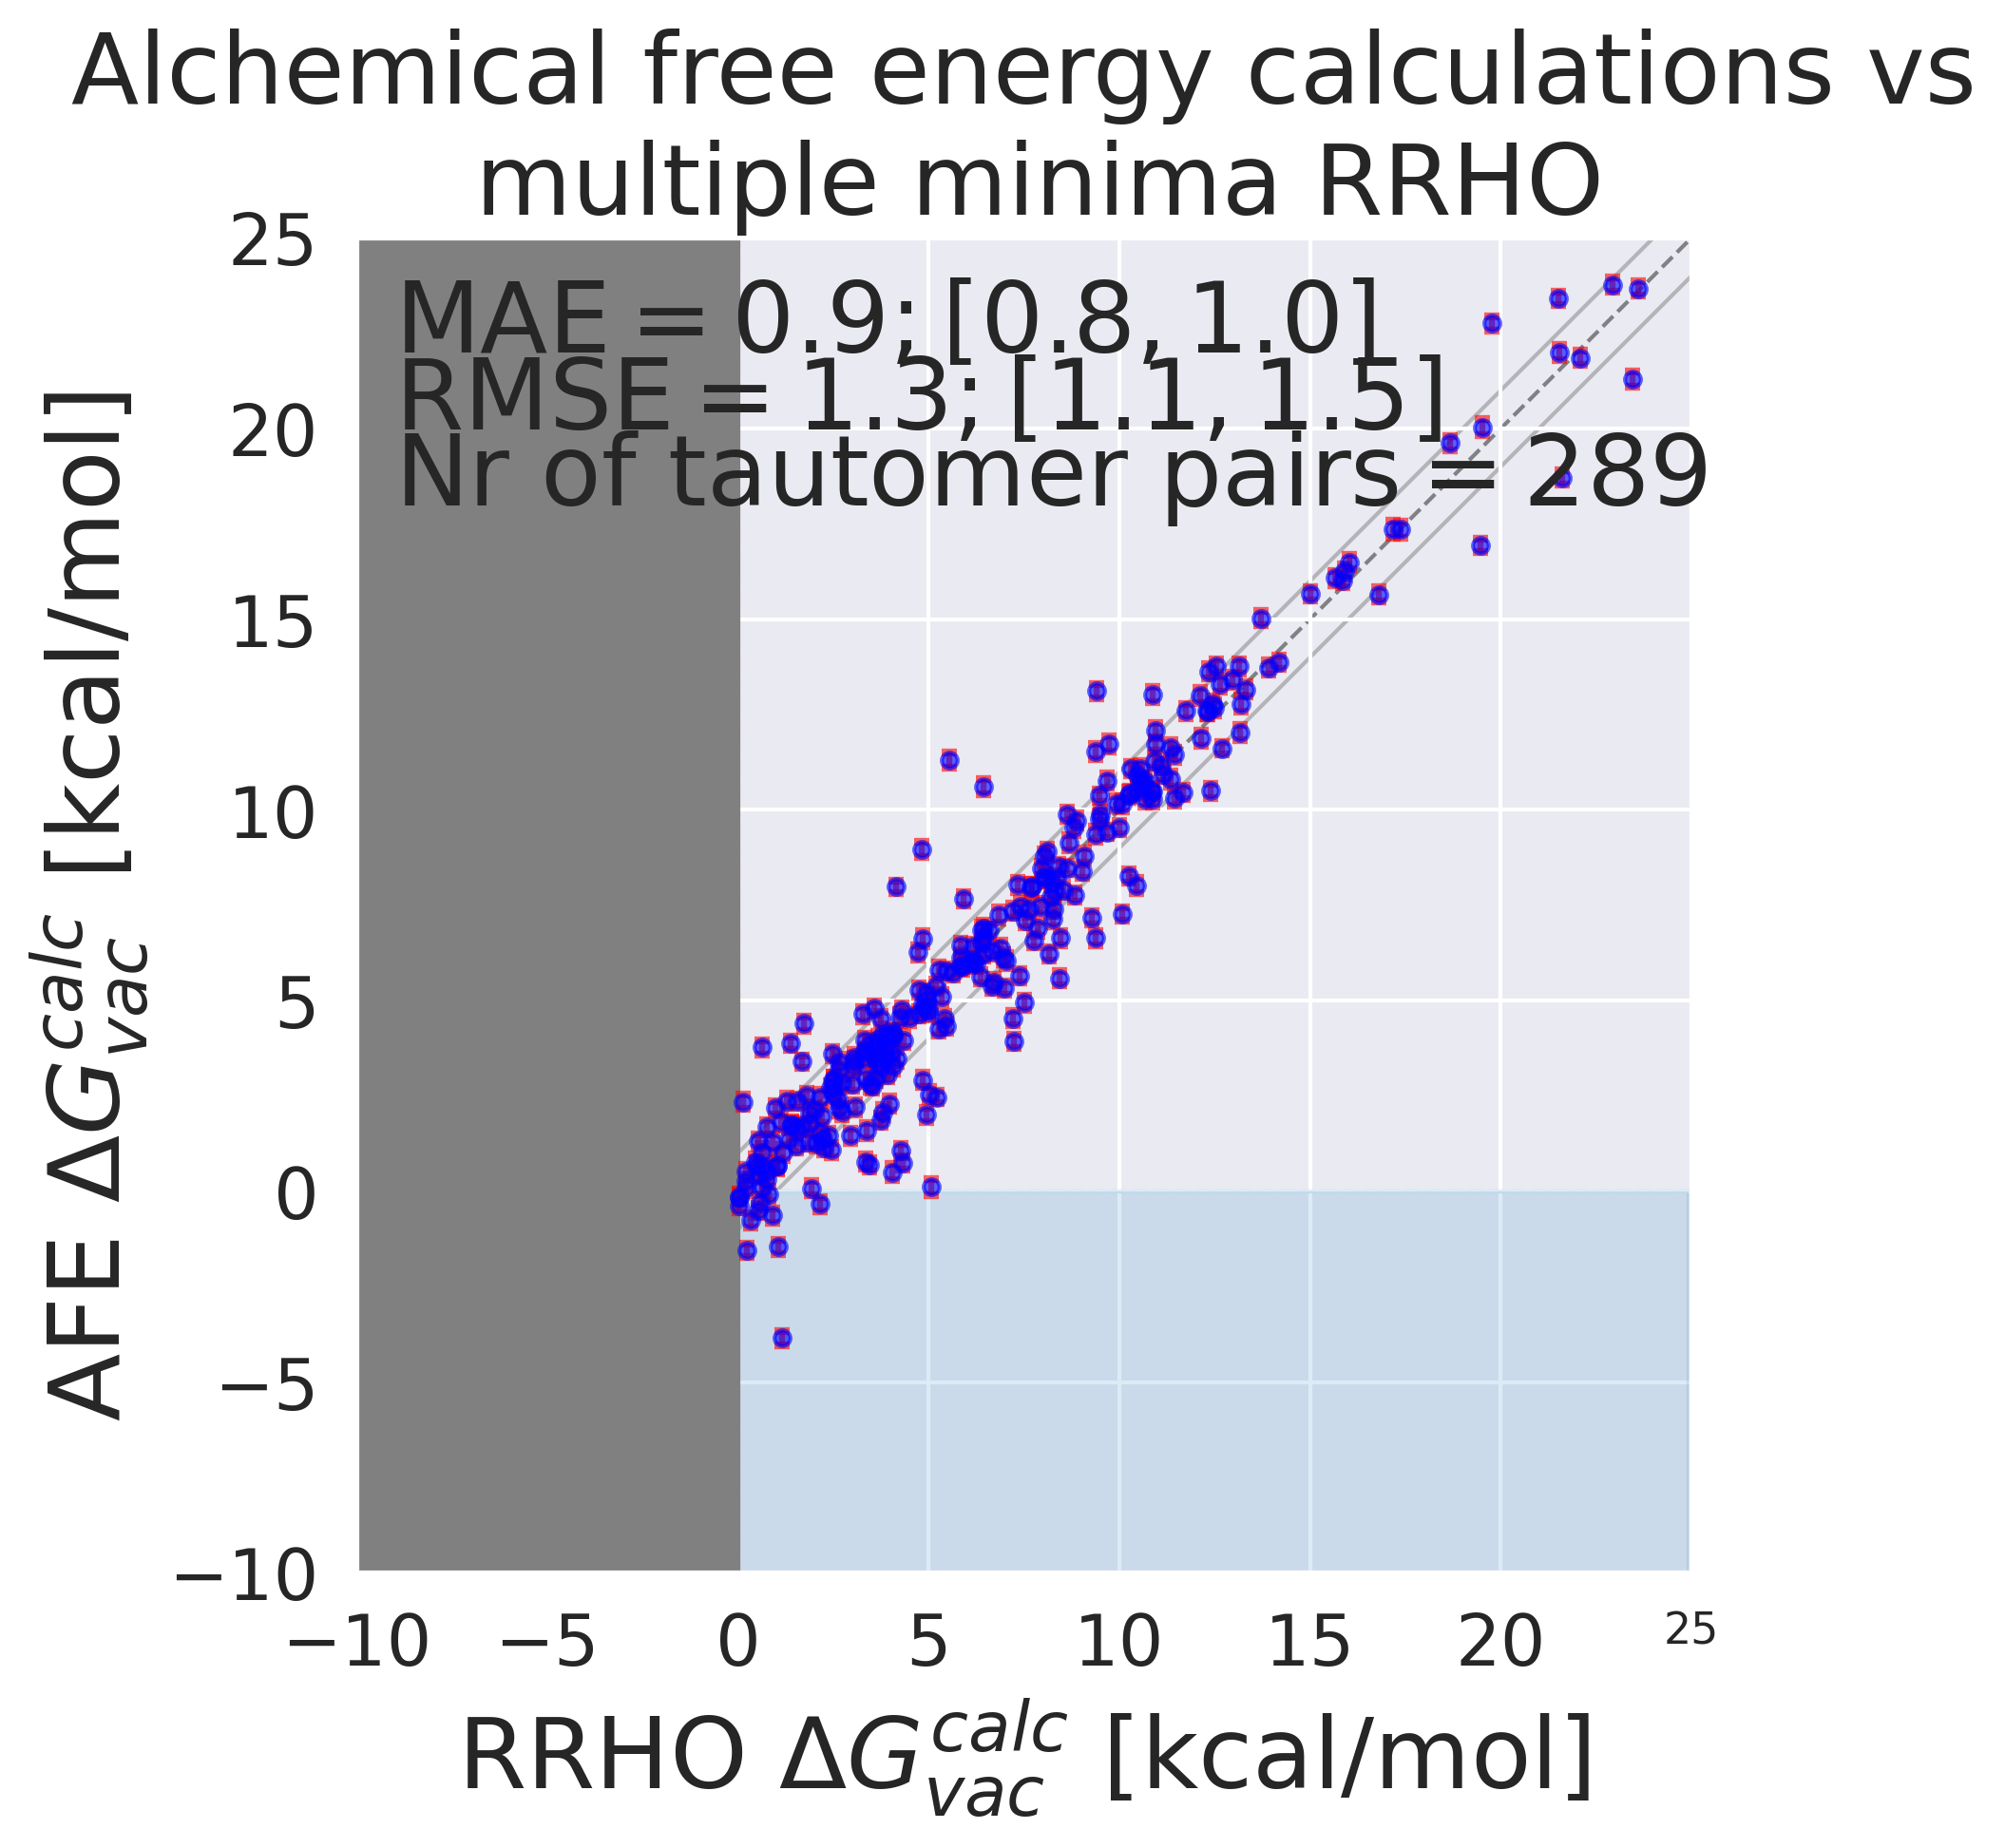

In [10]:
# comparing RRHO and AFE resutls

import seaborn as sns
sns.set_context('paper')
sns.set(color_codes=True)
x_list = []
y_list = []
yerror_list = []

for x, y, y_error in zip(dG_rrho, dG_rfe, dG_rfe_error):
    x = x.value_in_unit(unit.kilocalorie_per_mole)
    y = y
    if x < 0.0:
        x *= -1.
        y *= -1.
    
    x_list.append(x)
    y_list.append(y)
    yerror_list.append(y_error)
    
assert(len(x_list) == len(y_list))

error = []
for i in range(len(x_list)):
    error.append(abs(y_list[i] - x_list[i]))

f = plot_correlation_analysis(names, x_list, y_list, yerror=yerror_list, title='Alchemical free energy calculations vs\n multiple minima RRHO', x_label='RRHO $\Delta_{t} G_{vac}^{calc}$ [kcal/mol]', y_label='AFE $\Delta_{t} G_{vac}^{calc}$ [kcal/mol]', fontsize=25)
f

/home/mwieder/anaconda3/envs/ani/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mwieder/anaconda3/envs/ani/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


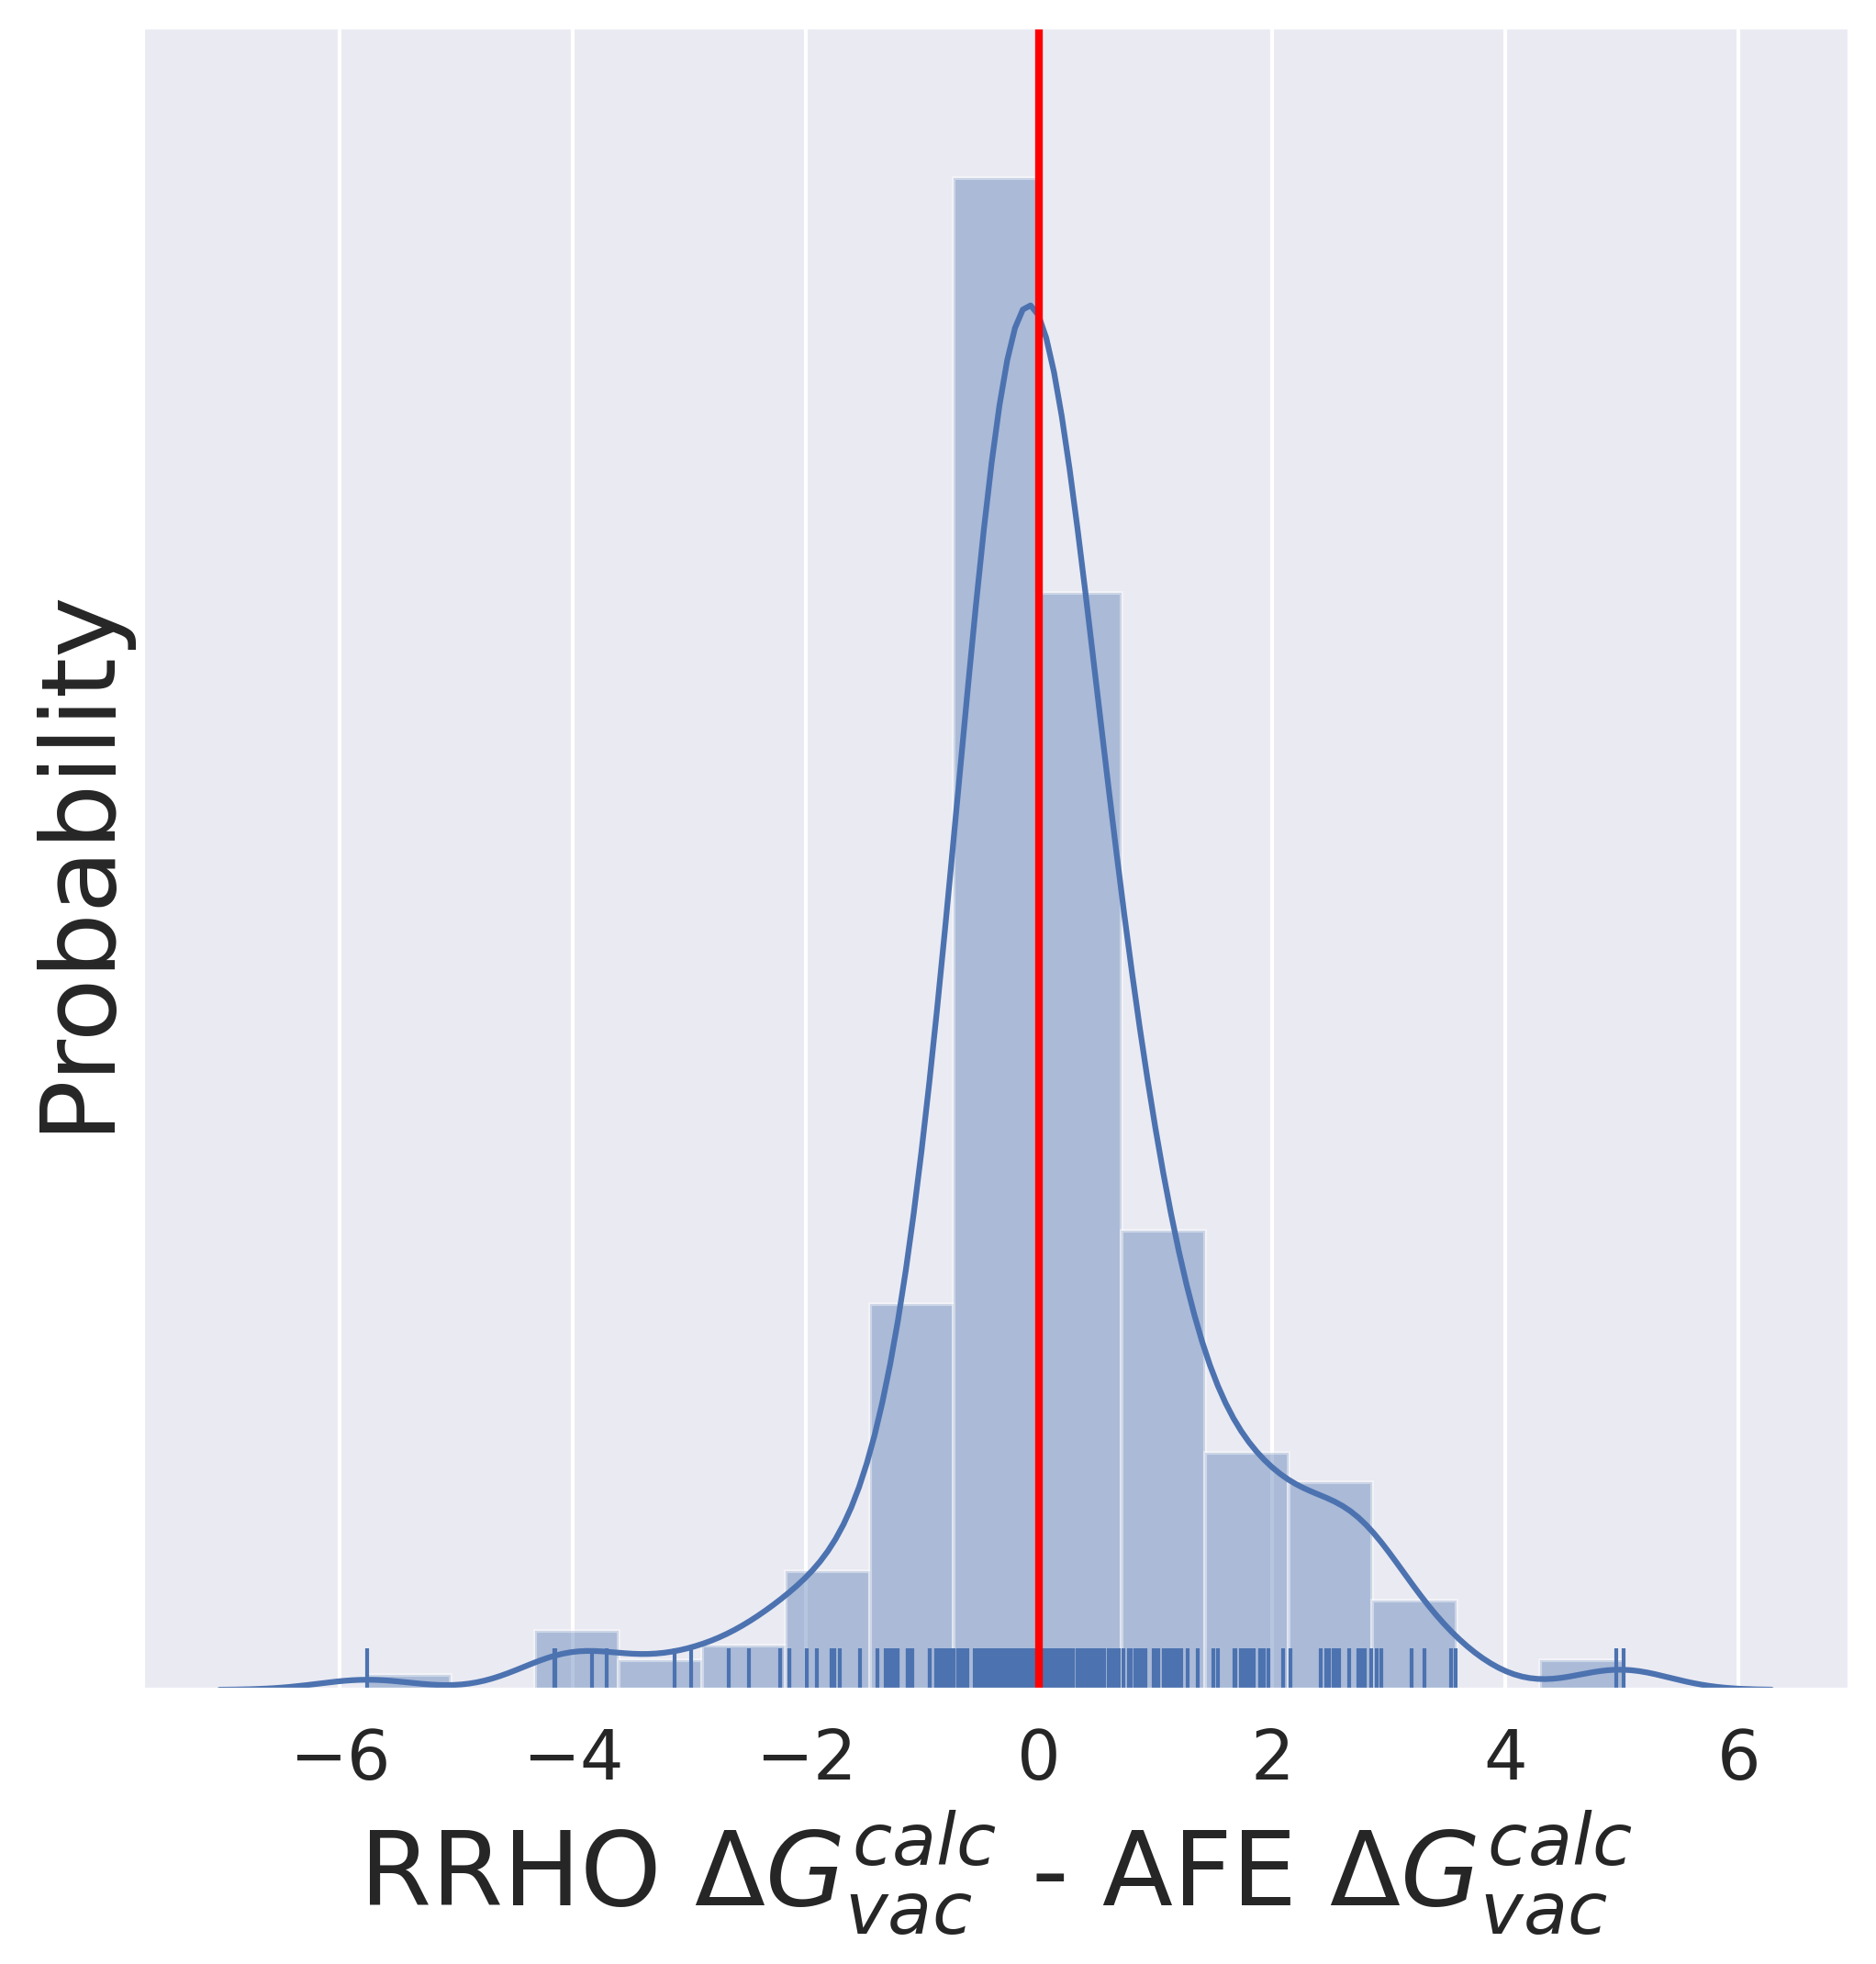

In [11]:
# plotting the difference between RRHO and AFE

plt.figure(figsize=[8, 8], dpi=300)
fontsize = 27
from neutromeratio.analysis import compute_kl_divergence, bootstrap_rmse_r
sns.distplot(np.array(x_list) - np.array(y_list), kde=True, rug=True, bins=15, label="RRHO  $-$ RFE")
rmse, mae, rho = (bootstrap_rmse_r(np.array(x_list), np.array(y_list), 1000))
plt.xlabel('RRHO $\Delta_{t} G_{vac}^{calc}$ - AFE $\Delta_{t} G_{vac}^{calc}$', fontsize=fontsize)
plt.ylabel('Probability', fontsize=fontsize)
#plt.legend(fontsize=20)
plt.axvline(0,0,15, color='red', linewidth=2)
ax = plt.gca()
plt.setp(ax.get_xticklabels(),  fontsize=18)
plt.setp(ax.get_yticklabels(),  fontsize=18)

plt.yticks([])
plt.show()

/home/mwieder/anaconda3/envs/ani/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mwieder/anaconda3/envs/ani/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


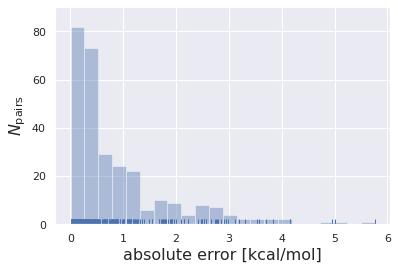

In [12]:
# generating a list of all molecules with an absolute error above 2 kcal/mol

count_over_2kcal_mol = 0
absolute_error = []
for x in (np.array(x_list) - np.array(y_list)):
    if abs(x) > 3.:
        count_over_2kcal_mol += 1
        
    absolute_error.append(abs(x))

import seaborn as sns
sns.set(color_codes=True)
sns.distplot(absolute_error, rug=True, kde=False)
plt.xlabel('absolute error [kcal/mol]', fontsize=16)
plt.ylabel('$N_{\mathrm{pairs}}$', fontsize=16)
plt.show()

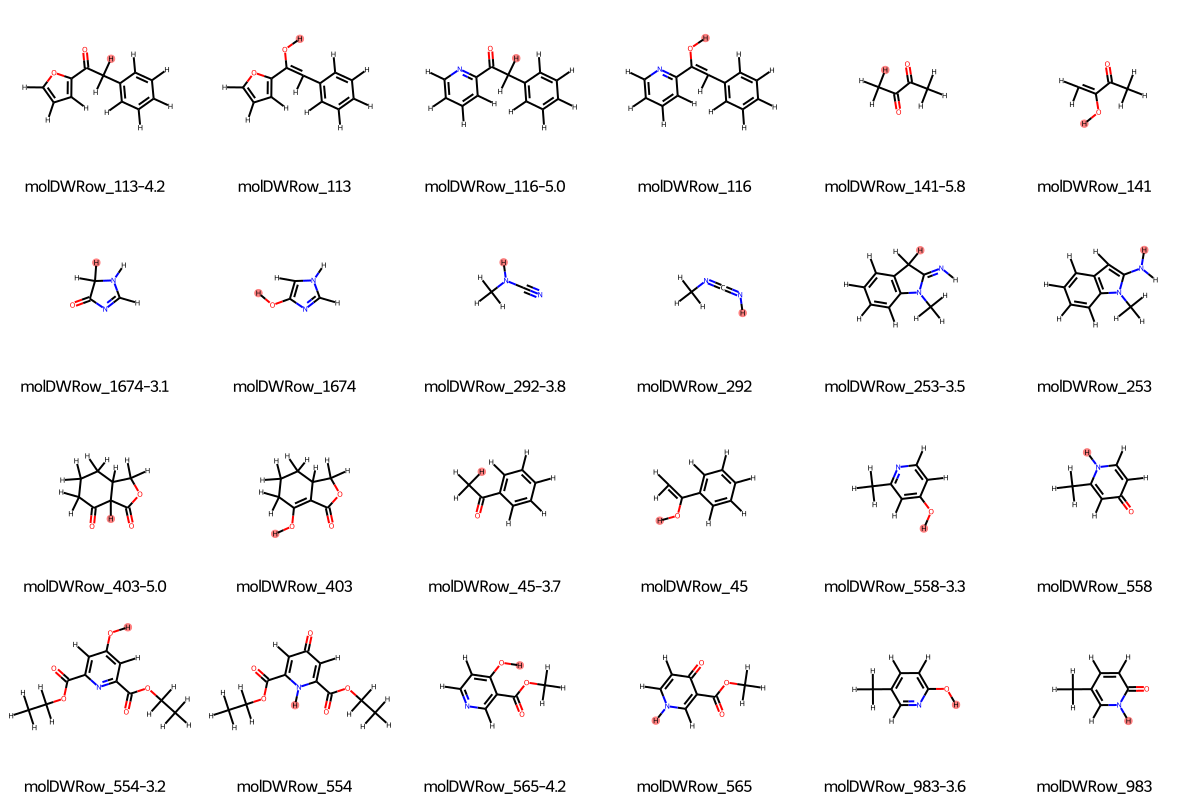

In [13]:
# writing out the molecules with an absolute error above 2 kcal/mol

import neutromeratio
import rdkit
from rdkit.Chem import AllChem
from rdkit.Chem import AllChem, Draw, rdFMCS

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)


mols = []
legends = []
highlight_atoms = []
for name, v in zip(names, error):
    if v < 3.0:
        continue
    #print(name)
    #print(v)
    legends.append(f"{name}-{round(v, 1)}")
    legends.append(name)
    t1_smiles = exp_results[name]['t1-smiles']
    t2_smiles = exp_results[name]['t2-smiles']

    # generate both rdkit mol
    m = neutromeratio.generate_rdkit_mol(t1_smiles)
    #AllChem.Compute2DCoords(m)
    mols.append(m)

    m = neutromeratio.generate_rdkit_mol(t2_smiles)
    #AllChem.Compute2DCoords(m)
    mols.append(m)


for t1, t2 in pairwise(mols):
    mcs = rdFMCS.FindMCS([t1,t2], bondCompare=rdFMCS.BondCompare.CompareAny,
                     timeout=120, atomCompare=rdFMCS.AtomCompare.CompareElements)
    mcsp = Chem.MolFromSmarts(mcs.smartsString, False)

    matchVs= [x.GetSubstructMatch(mcsp) for x in [t1,t2]]
    AllChem.Compute2DCoords(t1)
    coords = [t1.GetConformer().GetAtomPosition(x) for x in matchVs[0]]
    coords2D = [Geometry.Point2D(pt.x,pt.y) for pt in coords]

    # now generate coords for the other molecules using that reference:
    coordDict={}
    for i,coord in enumerate(coords2D):
        coordDict[matchVs[1][i]] = coord
    AllChem.Compute2DCoords(t2,coordMap=coordDict)

    s1 = (t1.GetSubstructMatch(mcsp))
    tmp = []
    for atom in t1.GetAtoms():
        if atom.GetIdx() not in s1:
            tmp.append(atom.GetIdx())
    highlight_atoms.append(tmp)

    s2 = (t2.GetSubstructMatch(mcsp))
    tmp = []
    for atom in t2.GetAtoms():
        if atom.GetIdx() not in s2:
            tmp.append(atom.GetIdx())
    highlight_atoms.append(tmp)


a = rdkit.Chem.Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(200, 200), legends=legends, highlightAtomLists=highlight_atoms, highlightBondLists=None, useSVG=True, maxMols=100)
w = open('/home/mwieder/test.svg', 'w')
w.write(a.data)
w.close()
a